# Imports

In [173]:
import os
import re
import nltk
import string
import pandas as pd
from nltk.corpus import words
# Download the english words dataset from nltk
nltk.download('words')

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud
import seaborn as sns
sns.set(style="darkgrid")

df_path = os.path.join('..', 'data', 'raw', 'ted_talks.csv')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\yevhe\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Load data

In [174]:
df = pd.read_csv(df_path)

# Initial exploration

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5631 entries, 0 to 5630
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   _id                 5631 non-null   int64 
 1   duration            5631 non-null   int64 
 2   event               5630 non-null   object
 3   likes               5631 non-null   object
 4   page_url            5631 non-null   object
 5   published_date      5631 non-null   object
 6   recorded_date       5629 non-null   object
 7   related_videos      5631 non-null   object
 8   speakers            5631 non-null   object
 9   subtitle_languages  5631 non-null   object
 10  summary             5631 non-null   object
 11  title               5631 non-null   object
 12  topics              5631 non-null   object
 13  transcript          4983 non-null   object
 14  views               5631 non-null   int64 
 15  youtube_video_code  5462 non-null   object
dtypes: int64(3), object(13)


In [176]:
# check missing values
print(f'Overall entries in dataset: {df.shape[0]}')

# count number of missing values in all columns
df.isnull().sum()

Overall entries in dataset: 5631


_id                     0
duration                0
event                   1
likes                   0
page_url                0
published_date          0
recorded_date           2
related_videos          0
speakers                0
subtitle_languages      0
summary                 0
title                   0
topics                  0
transcript            648
views                   0
youtube_video_code    169
dtype: int64

Column `transcript` - Some of the talks contain dancing and singing performances or simply had their transcripts removed, that's why we have so many missing values

In [177]:
df['transcript'] = df['transcript'].fillna('')

In [178]:
df.head()

_id  duration           event likes  \
0   21       992         TED2006   17K   
1    1       957         TED2006  110K   
2    7      1266         TED2006   60K   
3   47      1126  TEDGlobal 2005   80K   
4   55      1524         TED2006   14K   

                                            page_url        published_date  \
0  https://www.ted.com/talks/mena_trott_meet_the_...  2006-08-25T00:11:00Z   
1  https://www.ted.com/talks/al_gore_averting_the...  2006-06-27T00:11:00Z   
2  https://www.ted.com/talks/david_pogue_simplici...  2006-06-27T00:11:00Z   
3  https://www.ted.com/talks/david_deutsch_chemic...  2006-09-12T00:11:00Z   
4  https://www.ted.com/talks/jehane_noujaim_my_wi...  2006-07-25T00:11:00Z   

  recorded_date                                related_videos  \
0    2006-02-23      ["144","1282","1379","87","2302","2638"]   
1    2006-02-25  ["243","547","2093","74405","64693","83767"]   
2    2006-02-24    ["1725","2274","172","2664","2464","1268"]   
3    2005-07-14    ["2237","701","1095","1386","76211","242"]   
4    2006-02-26   ["2228","1476","800","2890","45233","2694"]   

                                            speakers  \
0  [{"name":"Mena Trott","occupation":"Blogger; c...   
1  [{"name":"Al Gore","occupation":"Climate advoc...   
2  [{"name":"David Pogue","occupation":"Technolog...   
3  [{"name":"David Deutsch","occupation":"Physici...   
4  [{"name":"Jehane Noujaim","occupation":"Filmma...   

                                  subtitle_languages  \
0  [{"name":"English","code":"en"},{"name":"Vietn...   
1  [{"name":"Greek","code":"el"},{"name":"Gujarat...   
2  [{"name":"Greek","code":"el"},{"name":"English...   
3  [{"name":"Greek","code":"el"},{"name":"English...   
4  [{"name":"English","code":"en"},{"name":"Vietn...   

                                             summary  \
0  The founding mother of the blog revolution, Mo...   
1  With the same humor and humanity he exuded in ...   
2  New York Times columnist David Pogue takes aim...   
3  Legendary scientist David Deutsch puts theoret...   
4  Jehane Noujaim unveils her 2006 TED Prize wish...   

                                         title  \
0      Meet the founder of the blog revolution   
1                  Averting the climate crisis   
2                             Simplicity sells   
3  Chemical scum that dream of distant quasars   
4                My wish: A global day of film   

                                              topics  \
0  [{"id":"4","name":"culture"},{"id":"13","name"...   
1  [{"id":"3","name":"climate change"},{"id":"4",...   
2  [{"id":"10","name":"technology"},{"id":"36","n...   
3  [{"id":"3","name":"climate change"},{"id":"4",...   
4  [{"id":"4","name":"culture"},{"id":"6","name":...   

                                          transcript    views  \
0  Over the past couple of days, as I've been pre...   589115   
1  Thank you so much, Chris. And it's truly a gre...  3671801   
2  (Music: "The Sound of Silence," Simon &amp; Ga...  2008487   
3  We've been told to go out on a limb and say so...  2694257   
4  I can't help but this wish: to think about whe...   489757   

  youtube_video_code  
0        RlBTxuWCuL8  
1        rDiGYuQicpA  
2        NEjZt0y6OOw  
3        gQliI_WGaGk  
4        QCFSrb6B5nw

We are only interested in textual columns, so we drop the rest.
Keep columns for now:
* summary
* title
* transcript

In [179]:
df = df[['summary', 'title', 'transcript']]

# Textual columns analysis

**Manual column inspection**

In [180]:
df['title'].sample(1).iloc[0]

'How to read music'

In [181]:
df['summary'].sample(1).iloc[0]

"Objects that fly faster than the speed of sound (like really fast planes) create a shock wave accompanied by a thunder-like noise: the sonic boom. These epic sounds can cause distress to people and animals and even damage nearby buildings. Katerina Kaouri details how scientists use math to predict sonic booms' paths in the atmosphere, where they will land, and how loud they will be. [Directed by Anton Bogaty, narrated by Addison Anderson, music by Michael Dow]."

Summary sometimes contains credits like `[Directed Eoin Duffy, narrated by Addison Anderson, sound by David Kamp]` or similar text in round brackets like `(Recorded June 16, 2020)`.
**We can savely get rid of it, unless in the future we need to search for certain people, dates or other information**

In [182]:
df['transcript'].sample(1).iloc[0]

'Alright. I\'d like to start with a small imagination exercise. Imagine you\'re sitting at this table, facing me right now. Now, I\'m going to ask you to push one of these cards towards me. So please imagine yourself pushing one of these cards towards me. OK, so take the number matching the card you pushed and remember it -- it\'s important for later. Now, I\'m going to flip through this deck of cards and ask you to choose a card that you will see in the deck. Are you ready? Alright, now that you have your card in mind, add the value of your card to your previous number. For example, if you chose the six of clubs, add six, if it\'s an ace, add one, and take 11 for any picture cards. Have you got your final number in mind? Perfect. So please take the item matching your final number. Now, here\'s what\'s funny. There are going to be a lot of people watching this video, and you all have different quirks with different preferences. And yet, the vast majority of you right now is thinking ab

Transcript contains many occurences of `(Applause)`, `(Applause ends)`, `(Audience)`, `(Laughter)`, `(Gasps)`, `(Cheers)` describing audience reaction. Generally it's enclosed in round brackets `()`.
**Such words have no contextual meaning, so we can find and remove them later.**

**Remove text inside round and square brackets from summary and transcript**

In [183]:
def remove_bracketed_text(input_text):
    # Define a regular expression pattern to find text inside round or square brackets
    pattern = r'[\(\[]([^()\[\]]*)[\)\]]'

    # Use re.findall to extract all occurrences of the pattern
    output_text = re.sub(pattern, '', input_text)

    return output_text

# Example usage:
text_with_round_brackets = df['summary'].loc[9]
text_without_brackets = remove_bracketed_text(text_with_round_brackets)

print("Original text:", text_with_round_brackets)
print("Processed text:", text_without_brackets)

text_with_square_brackets = df['summary'].loc[5437]
text_without_brackets = remove_bracketed_text(text_with_square_brackets)

print("\nOriginal text:", text_with_square_brackets)
print("Processed text:", text_without_brackets)


Original text: Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.
Processed text: Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures  creativity.

Original text: The word "normal" is often used as a synonym for "typical," "expected," or even "correct." By that logic, most people should fit the description of normal. But time and time again, so-called normal descriptions of our bodies, minds, and perceptions have turned out to match almost no one. So what does normal actually mean— and should we be relying on it so much? Yana Buhrer Tavanier investigates. [Directed by Eoin Duffy, narrated by Pen-Pen Chen, music by Adam Alexander, Bamm Bamm Wolfgang].
Processed text: The word "normal" is often used as a synonym for "typical," "expected," or even "correct." By that logic, most people should fit the description of normal. But time 

In [184]:
df['summary'] = df['summary'].apply(remove_bracketed_text)
df['transcript'] = df['transcript'].apply(remove_bracketed_text)

### Visualizations

**Generate wordcloud**

In [187]:
def generate_wordcloud(words_list, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        ' '.join(words_list)
    )
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

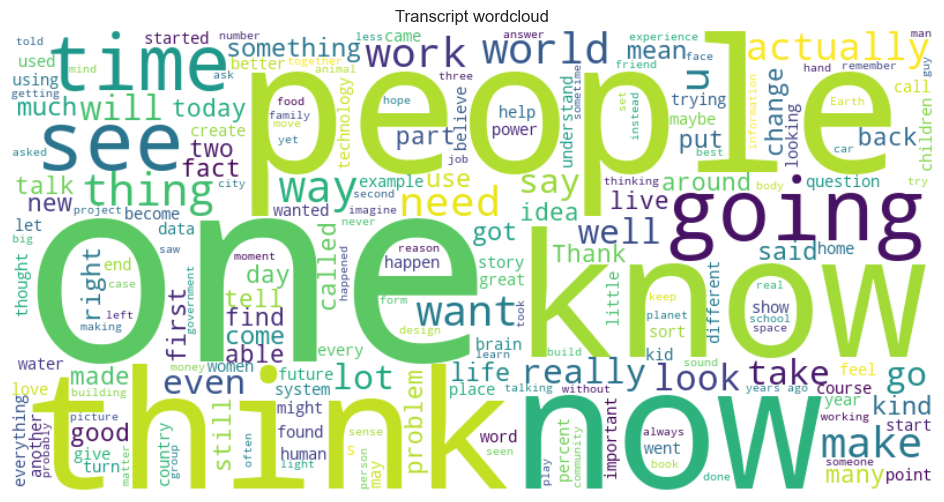

In [189]:
generate_wordcloud(df['transcript'].explode().dropna(), 'Transcript wordcloud')

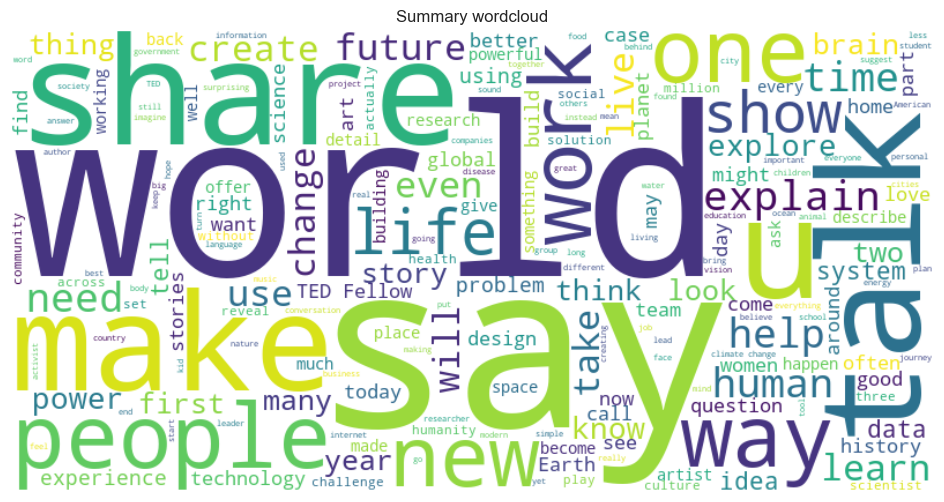

In [190]:
generate_wordcloud(df['summary'].explode().dropna(), 'Summary wordcloud')

**Get text word count for each `summary`, `title` and `transcript`**

In [7]:
summary_len_series = df['summary'].apply(lambda row: len(row.split()))
title_len_series = df['title'].apply(lambda row: len(row.split()))
transcript_len_series = df['transcript'].apply(lambda row: len(row.split()) if isinstance(row, str) else 0)

In [8]:
word_describe_df = pd.DataFrame({
    'summary_words': summary_len_series.describe(),
    'title_words': title_len_series.describe(),
    'transcript_words': transcript_len_series.describe()
})

word_describe_df

summary_words  title_words  transcript_words
count    5631.000000  5631.000000       5631.000000
mean       60.413958     6.966613       1522.532055
std        19.977812     2.483899       1141.800565
min         5.000000     1.000000          0.000000
25%        45.000000     5.000000        665.000000
50%        60.000000     7.000000       1435.000000
75%        74.000000     9.000000       2215.500000
max       201.000000    17.000000      12076.000000

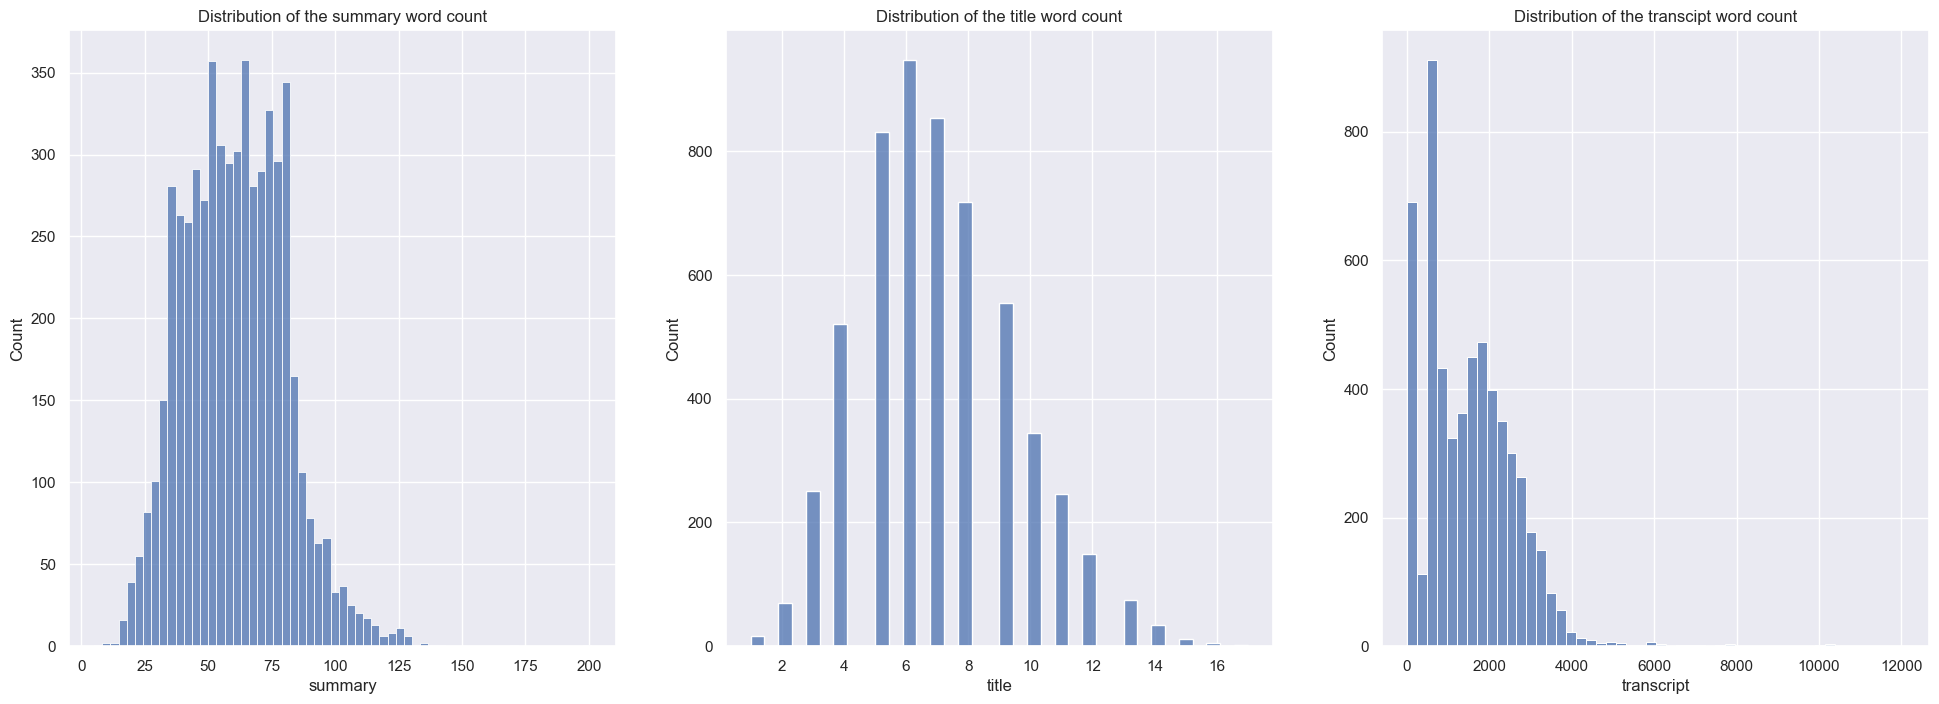

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

ax1 = sns.histplot(ax=axes[0], data=summary_len_series)
ax2 = sns.histplot(ax=axes[1], data=title_len_series)
ax3 = sns.histplot(ax=axes[2], data=transcript_len_series, bins=50)

ax1.title.set_text('Distribution of the summary word count')
ax2.title.set_text('Distribution of the title word count')
ax3.title.set_text('Distribution of the transcipt word count')

In [10]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Summary', 'Title', 'Transcript'))
fig.add_trace(go.Box(y=summary_len_series, name='Summary'), row=1, col=1)
fig.add_trace(go.Box(y=title_len_series, name='Title'), row=1, col=2)
fig.add_trace(go.Box(y=transcript_len_series, name='Transcript'), row=1, col=3)

**Get number of tokens for each `title`, `summary` and `transcript`**

We'll use OpenAI `text-embedding-ada-002` model to generate embeddings, so we need to use appropriate `cl100k_base` tokenizer.

In [14]:
import tiktoken

encoder = tiktoken.get_encoding('cl100k_base')

In [52]:
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    num_tokens = len(encoder.encode(string))
    return num_tokens

In [25]:
title_token_count_series = df['title'].apply(lambda text: num_tokens_from_string(text))
summary_token_count_series = df['summary'].apply(lambda text: num_tokens_from_string(text))
transcript_token_count_series = df['transcript'].apply(lambda text: num_tokens_from_string(text) if isinstance(text, str) else 0)

tokens_describe_df = pd.DataFrame({
    'summary_tokens': summary_token_count_series.describe(),
    'title_tokens': title_token_count_series.describe(),
    'transcript_tokens': transcript_token_count_series.describe()
})
tokens_describe_df

summary_tokens  title_tokens  transcript_tokens
count     5631.000000   5631.000000        5631.000000
mean        76.381282      8.192328        1874.929320
std         25.599728      2.902829        1395.486647
min          8.000000      2.000000           0.000000
25%         57.000000      6.000000         863.000000
50%         75.000000      8.000000        1758.000000
75%         94.000000     10.000000        2719.500000
max        364.000000     30.000000       13939.000000

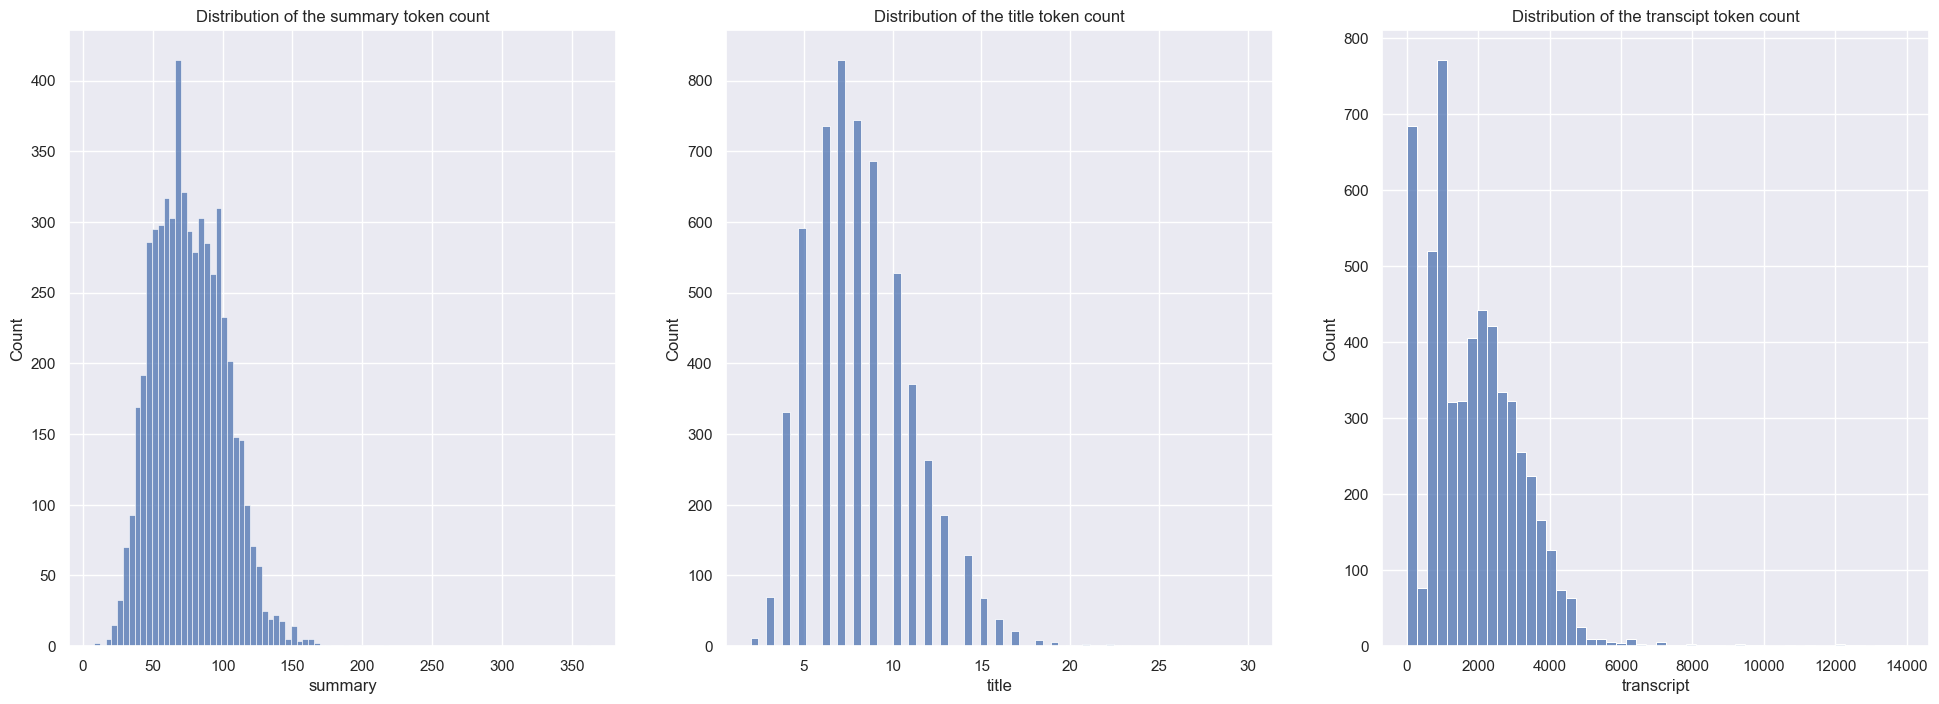

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

ax1 = sns.histplot(ax=axes[0], data=summary_token_count_series)
ax2 = sns.histplot(ax=axes[1], data=title_token_count_series)
ax3 = sns.histplot(ax=axes[2], data=transcript_token_count_series, bins=50)

ax1.title.set_text('Distribution of the summary token count')
ax2.title.set_text('Distribution of the title token count')
ax3.title.set_text('Distribution of the transcipt token count')

In [54]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('Summary', 'Title', 'Transcript'))
fig.add_trace(go.Box(y=summary_token_count_series, name='Summary token count'), row=1, col=1)
fig.add_trace(go.Box(y=title_token_count_series, name='Title token count'), row=1, col=2)
fig.add_trace(go.Box(y=transcript_token_count_series, name='Transcript token count'), row=1, col=3)

If we were to use `text-embedding-ada-002` model, we can only use 8191 tokens as input, so we need to check how many texts have more than 8191 tokens (Reference: [OpenAI docs](https://platform.openai.com/docs/guides/embeddings/second-generation-models))

In [31]:
print(f"Number of transcripts with more than 8191 tokens: {sum(transcript_token_count_series > 8191)}")

Number of transcripts with more than 8191 tokens: 23


# Conclusion

Some preprocessing is required to remove unwanted text from `summary` and `transcript` columns. Embedding models don't require extensive preprocessing, as they encode meaning from the sentence as a whole.
We'll use OpenAI embeddings model, so we need to either manipulate transcript text whose token count is above 8191 so that it fits the model input and no important information is lost, or not use transcripts but summaries and titles instead.